In [17]:
# Cargar librerías
import pandas as pd  # Manejo de dataframes
import numpy as np  # Manejo de arrays
import funciones  # Funciones propias

In [18]:
# Cargar datos de sqlite3
import sqlite3

conn = sqlite3.connect("data/df.db")  # Conectar a la base de datos (ruta)
df = pd.read_sql_query("SELECT * FROM df", conn)  # Leer la tabla df
conn.close()  # Cerrar la conexión
df.head()  # Mostrar las primeras 5 filas

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,...,mean_time,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,target,retirementDate,retirementType,resignationReason
0,51,Travel_Rarely,Sales,6,2,Life Sciences,Female,1,Healthcare Representative,Married,...,7.373651,3.0,4.0,2.0,3,3,0,None,No,No
1,31,Travel_Frequently,Research & Development,10,1,Life Sciences,Female,1,Research Scientist,Single,...,7.718969,3.0,2.0,4.0,2,4,1,2016-10-15 00:00:00,Resignation,Others
2,32,Travel_Frequently,Research & Development,17,4,Other,Male,4,Sales Executive,Married,...,7.013240,2.0,2.0,1.0,3,3,0,None,No,No
3,38,Non-Travel,Research & Development,2,5,Life Sciences,Male,3,Human Resources,Married,...,7.193678,4.0,4.0,3.0,2,3,0,None,No,No
4,32,Travel_Rarely,Research & Development,10,1,Medical,Male,1,Sales Executive,Single,...,8.006175,4.0,1.0,3.0,3,3,0,None,No,No


In [19]:
# Quitar retirementDate, retirementType y retirementReason porque puede generar un sesgo en el modelo
df.drop(["retirementDate", "retirementType", "resignationReason"], axis=1, inplace=True)


# Reemplazar los valores nan de EnvironmentSatisfaction, JobSatisfaction y WorkLifeBalance por la moda de ese empleado en su departamento
df["EnvironmentSatisfaction"] = df.groupby("Department")[
    "EnvironmentSatisfaction"
].transform(lambda x: x.fillna(x.mode()[0]))

df["JobSatisfaction"] = df.groupby("Department")["JobSatisfaction"].transform(
    lambda x: x.fillna(x.mode()[0])
)
df["WorkLifeBalance"] = df.groupby("Department")["WorkLifeBalance"].transform(
    lambda x: x.fillna(x.mode()[0])
)

In [20]:
from sklearn.model_selection import train_test_split

# Separación de caracteristicas y target (X , y)
y = df.target
X = df.drop(["target"], axis=1)

# Separación en conjuntos de train y test 90% - 10%
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

# Mostrar los tamaños de los conjuntos
print("Tamaño de X_train: ", X_train.shape)
print("Tamaño de X_test: ", X_test.shape)

Tamaño de X_train:  (3943, 25)
Tamaño de X_test:  (439, 25)


Se realizó una separación 90-10 para los datos de entrenamiento y test respectivamente. Quedando de la siguiente manera: 3943 datos para X_train y 439 para X_test

Los datos de test solo se usan para evaluar el modelo final, no para entrenarlo. Por eso, no se deben usar para entrenar el modelo ni para optimizar hiperparámetros.

In [21]:
# Estandarización de los datos
funciones.scaler(X, X_train, X_test)

# Convertir a dummy las variables categóricas
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
print("Variables categóricas convertidas a dummy")

Variables numéricas estandarizadas
Variables categóricas convertidas a dummy


Para train y test se estandarizaron los datos numéricos y se convirtieron las variables categóricas en dummies para poder entrenar los modelos

# Modelos

La métrica que usaremos será el RECALL, teniendo en cuenta que por las caracteristicas del problema buscamos reducir al máximo que el algoritmo prediga que alguien no se va a ir cuando realmente si se va a ir (FALSOS NEGATIVOS) ya que esto le genera un costo muy elevado a la empresa y por otro lado, que el algoritmo prediga que alguien se va a ir cuando realmente no se va a ir (FALSOS POSITIVOS) no genera un costo tan elevado como el anterior.

Se analizarán los modelos de LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier y XGBClassifier con validación cruzada de 10 folds

In [16]:
# Métrica del modelo
from sklearn.metrics import recall_score

"""
RECALL: Queremos que tenga cuidado con falsos negativos (entre más alto mejor)
PRECISION: Queremos que tenga cuidado con falsos positivos (entre más alto mejor)
F1 SCORE: Es una combinación de recall y precision (entre más alto mejor)

"""
# Lista de modelos que tienen más interpretabilidad para clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier  # Ensamble con bagging
from sklearn.ensemble import GradientBoostingClassifier  # Ensamble con boosting
from xgboost import XGBClassifier  # Ensamble con boosting


models = {
    "LogisticRegression": LogisticRegression(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "XGBClassifier": XGBClassifier(),
}


funciones.train_models_cv(models, X_train, y_train, cv=10, metric="recall")

LogisticRegression
recall mean train: 0.258 +/- 0.008
recall mean test: 0.243 +/- 0.043

DecisionTreeClassifier
recall mean train: 1.000 +/- 0.000
recall mean test: 0.971 +/- 0.011

RandomForestClassifier
recall mean train: 1.000 +/- 0.000
recall mean test: 0.980 +/- 0.014

GradientBoostingClassifier
recall mean train: 0.576 +/- 0.010
recall mean test: 0.464 +/- 0.055

XGBClassifier
recall mean train: 1.000 +/- 0.000
recall mean test: 0.986 +/- 0.013



Podemos analizar lo siguiente:
* LogisticRegression, tiene un recall bajo con overfitting bajo (0.015 puntos de diferencia en test y train)
* GradientBoostingClassifier tiene un recall medio con overfitting medio (0.10 puntos de diferencia en test y train)
* DecisionTree, RandomForest y XGBClassifier vemos que tienen un recall demasiado alto con overfitting bajo (0.014 puntos de diferencia en test y train)
* Tomaremos el XGBClassifier como modelo final, ya que buscamos un recall alto y un overfitting bajo, su punto de mejora sería buscar un mejor recall sin aumentar el overfitting (diferencia entre test y train)

# Curva de aprendizaje

Interpretación de la curva de aprendizaje:
* Overfitting: hay una diferencia muy grande entre la linea de train y la linea de test, nuestro modelo se aprendió muy bien los datos de train pero no es capaz de generalizar para datos nuevos
* Underfitting: las dos lineas están muy juntas pero con un score muy bajo, nuestro modelo no aprendió bien los datos de train y tampoco es capaz de generalizar para datos nuevos

(array([1., 1., 1., 1., 1.]),
 array([0.86228748, 0.91477671, 0.94749663, 0.98021525, 0.99721005]))

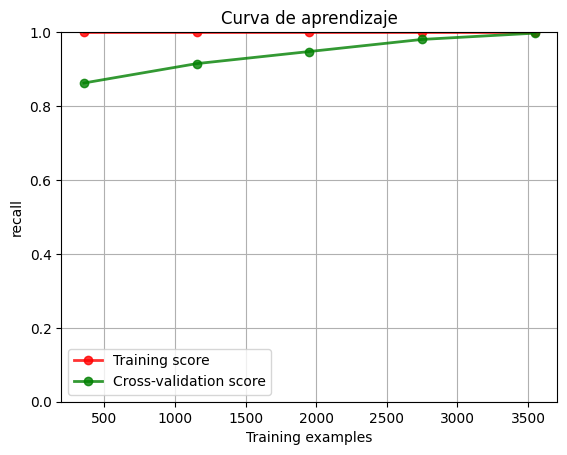

In [226]:
# Curva de aprendizaje
funciones.plot_learning_curve(
    models["XGBClassifier"],
    "Curva de aprendizaje",
    X_train,
    y_train,
    ylim=(0, 1),
    cv=10,
    score=metric,
)

En este caso, la métrica es recall la cuál entre más grande es mejor, vemos que el train inicia en 1 y el test en 0.86 y al final se acercan, por lo que el modelo no está sobreajustado.

Es sospechoso que el desempeño del modelo sea tan alto, pero podríamos esperar a predecir con los datos de test para ver si se mantiene. Se afinaran hiperparámetros para ver si se puede mejorar el recall sin aumentar el overfitting, de lo contrario se usará el modelo inicial de mayor recall.

# Optimización de hiperparámetros (no ejecutar)

Aunque no era necesario mejorar el modelo ya que tenía un recall alto y un overfitting bajo, se decidió optimizar hiperparámetros para ver si se podía mejorar el recall sin aumentar el overfitting. 

Se harán 2 búsquedas de hiperparámetros con GridSearchCV y validación cruzada con 5 folds, la primera con los hiperparámetros por defecto para reducir overfitting indicados en la [documentación](https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html) de XGBoost y la segunda con los hiperparámetros que se obtuvieron en la primera búsqueda, escogiendo valores cercanos a los que se obtuvieron en la primera.



In [213]:
# Optimizar hiperparámetros de XGBoost con GridSearchCV
from sklearn.model_selection import GridSearchCV

"""
# Definir los hiperparámetros a optimizar 1RA VUELTA  (totalling 11520 fits, 42 min aprox)
param_grid = {
    "max_depth": [4, 5, 6, 7],  # Pequeño = evita overfitting
    "gamma": [0.1, 0.3, 0.5, 0.7],  # Grande = evita overfitting (pred=0)
    "min_child_weight": [1, 3, 5, 7],  # Grande = evita overfitting (pred=1)
    "learning_rate": [0.1, 0.3, 0.5, 0.7],  # Pequeño = evita overfitting (pred=0.3)
    "subsample": [0.5, 0.7, 1],  # Pequeño = evita overfitting (pred=1)
    "colsample_bytree": [0.5, 0.7, 1],  # Pequeño = evita overfitting (pred=1)
}
"""

# Definir los hiperparámetros a optimizar 2DA VUELTA (totalling 4860 fits, 6 min aprox )
param_grid = {
    "max_depth": [3, 4, 5],  # Pequeño = evita overfitting
    "gamma": [0.01, 0, 1],  # Grande = evita overfitting (pred=0)
    "min_child_weight": [1, 3, 5],  # Grande = evita overfitting (pred=1)
    "learning_rate": [0.1, 0.3, 0.5, 0.7],  # Pequeño = evita overfitting (pred=0.3)
    "subsample": [0.3, 0.5, 0.7],  # Pequeño = evita overfitting (pred=1)
    "colsample_bytree": [0.3, 0.5, 0.7],  # Pequeño = evita overfitting (pred=1)
}

# Definir el modelo
xgb = XGBClassifier(
    # eval_metric="logloss",  # Función de pérdida a optimizar, diferente a la métrica usada
    # early_stopping_rounds=10,  # Detener el entrenamiento si no mejora en 10 iteraciones
    tree_method="hist",  # Agiliza el entrenamiento
    random_state=42,  # Semilla para reproducibilidad
)

# Definir la búsqueda
grid_search = GridSearchCV(
    xgb,  # Modelo
    param_grid,  # Hiperparámetros
    scoring=metric,  # Métrica de evaluación
    cv=5,  # Número de folds = 5 porque no tenemos muchos datos
    n_jobs=-1,  # Número de núcleos a usar (-1 usa todos los disponibles)
    return_train_score=True,  # Devolver los resultados de train y test
    verbose=1,  # Mostrar la cantidad de modelos a entrenar
)

# Entrenar la búsqueda
grid_search.fit(
    X_train,  # Características
    y_train,  # Target
    # eval_set=[(X_train, y_train)],  # Conjunto de eval: si usa early_stopping...
    # verbose=False,  # Progreso de eval: si usa early_stopping...
)

# Crear tabla resultados de la búsqueda parámetro usado y su score en train y test
results = pd.DataFrame(grid_search.cv_results_)
results = results[
    [
        "param_max_depth",
        "param_gamma",
        "param_min_child_weight",
        "param_learning_rate",
        "param_subsample",
        "param_colsample_bytree",
        "mean_train_score",
        "mean_test_score",
        "std_train_score",
        "std_test_score",
    ]
]

# Promedio y desviación estándar de las métricas del recall
print("\n")
print("---------------------Mejores hiperparámetros---------------------")
print(grid_search.best_params_)
print("\n")
print("---------------------Métricas---------------------")
print(
    f"Recall mean train: {grid_search.cv_results_['mean_train_score'][grid_search.best_index_]:.3f} +/- {grid_search.cv_results_['std_train_score'][grid_search.best_index_]:.3f}"
)
print(
    f"Recall mean test: {grid_search.cv_results_['mean_test_score'][grid_search.best_index_]:.3f} +/- {grid_search.cv_results_['std_test_score'][grid_search.best_index_]:.3f}"
)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


---------------------Mejores hiperparámetros---------------------
{'colsample_bytree': 0.5, 'gamma': 0.01, 'learning_rate': 0.7, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.7}


---------------------Métricas---------------------
Recall mean train: 1.000 +/- 0.000
Recall mean test: 0.961 +/- 0.017


En este caso no queremos maximizar la métrica a como de lugar, queremos buscar que hiperparámetros nos dan menor diferencia entre train y test para ver si nuestra búsqueda de reducir el overfitting fue exitosa.

In [214]:
# Calcular la diferencia en valor absoluto entre mean train y mean test y crear una nueva columna
results["diff"] = abs(results["mean_train_score"] - results["mean_test_score"])

# Filtrar valores mean_train_score menores a 1
filtro = results[results["mean_train_score"] <= 1]

# Ordenar los valores por la columna diff de menor a mayor
filtro.sort_values("diff", ascending=True).head(10)

,param_max_depth,param_gamma,param_min_child_weight,param_learning_rate,param_subsample,param_colsample_bytree,mean_train_score,mean_test_score,std_train_score,std_test_score,diff
428,5,0.01,3,0.7,0.7,0.5,1.0,0.961467,0.0,0.016886,0.038533
506,5,0,1,0.5,0.7,0.5,1.0,0.959928,0.0,0.027278,0.040072
424,5,0.01,1,0.7,0.5,0.5,1.0,0.958354,0.0,0.022216,0.041646
721,5,0.01,1,0.5,0.5,0.7,1.0,0.956875,0.0,0.023103,0.043125
398,5,0.01,1,0.5,0.7,0.5,1.0,0.956828,0.0,0.028679,0.043172
847,4,0,1,0.7,0.5,0.7,1.0,0.956804,0.0,0.027924,0.043196
209,5,0,1,0.7,0.7,0.3,1.0,0.956792,0.0,0.028808,0.043208
101,5,0.01,1,0.7,0.7,0.3,1.0,0.956792,0.0,0.028808,0.043208
208,5,0,1,0.7,0.5,0.3,1.0,0.955277,0.0,0.021552,0.044723
829,5,0,1,0.5,0.5,0.7,1.0,0.953775,0.0,0.027088,0.046225


Esta tabla está ordenada de mayor a menor diferencia en train y test y nos da un recall en test de 0.96, este es menor que antes de afinar parámetros que era de 0.98, esto sucede porque la mayoría de hiperparámetros que se usaron fueron para reducir el overfitting, pero no se logró mejorar el recall. Por lo que se decide usar el modelo inicial.

# Mejor modelo

Recall en test: 1.000


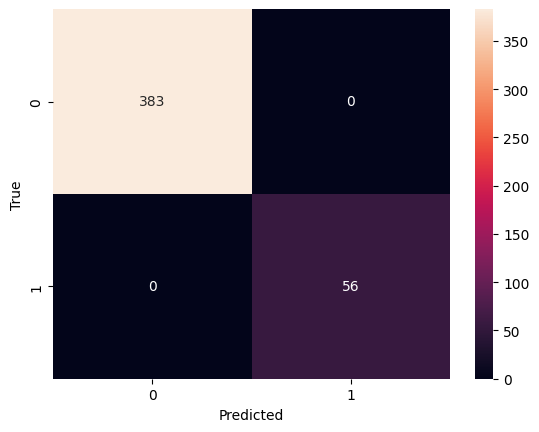

<Axes: title={'center': 'Feature importance'}, ylabel='Features'>

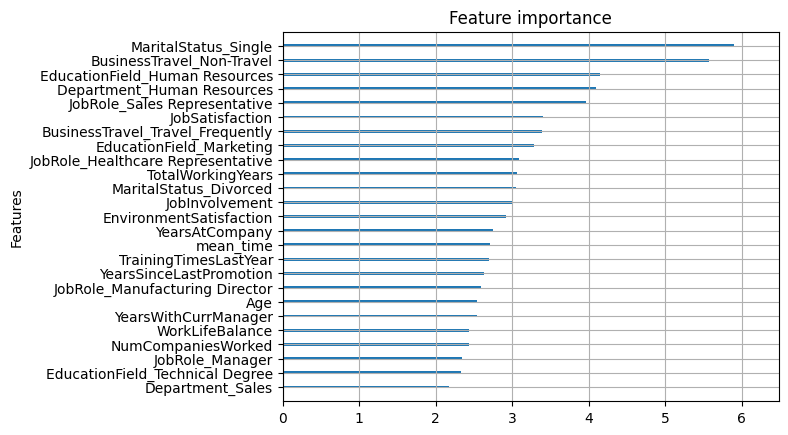

In [7]:
# Predicciones en el conjunto de test con recall
best_model = models["XGBClassifier"]

y_pred = best_model.predict(X_test)
print(f"Recall en test: {recall_score(y_test, y_pred):.3f}")

# Matriz de confusión
from sklearn.metrics import confusion_matrix  # Matriz de confusión
import seaborn as sns  # Gráficos estadísticos
import matplotlib.pyplot as plt  # Gráficos

y_pred = best_model.predict(X_test)  # Predicciones
cm = confusion_matrix(y_test, y_pred)  # Matriz de confusión
sns.heatmap(cm, annot=True, fmt="d")  # Gráfico de la matriz de confusión
plt.xlabel("Predicted")  # Etiqueta eje x
plt.ylabel("True")  # Etiqueta eje y
plt.show()  # Mostrar gráfico

"""
Podemos ver las variables importantes de los modelos basados en arboles según 3 medidas diferentes
1. weight: Número de veces que el modelo usó la variable para dividir los nodos
2. gain: Contribución de cada variable para mejorar la predicción
3. cover: Número de veces que cada variable en las observaciones de entrenamiento
"""

# Tabla de las 25 características más importantes ordenadas de mayor a menor de XGBoost con gain
import xgboost

xgboost.plot_importance(
    best_model,
    max_num_features=25,
    importance_type="gain",
    show_values=False,
    xlabel=None,
)

Al hacer las predicciones nos arroja un recall de 1 en los datos de test, que no se habían tomado antes, por lo que se puede decir que el modelo generaliza muy bien en los 439 datos de test.

La matriz de dispersión nos muestra que efectivamente el modelo predice muy bien los datos de test, ya que todos los puntos están en la diagonal.

Vemos que las caracteristicas más importantes están graficadas de mayor a menor importancia

Hay que tener en cuenta que estas caracteristicas son calculadas con el tipo de importancia "gain", que es la ganancia promedio de la variable cuando es usada en un árbol de decisión. Por lo que no nos dice que caracteristicas son más importantes para el modelo, sino que caracteristicas son más usadas en los árboles de decisión.

Es por eso que se utiliza la librería SHAP, que nos dice que caracteristicas son más importantes para el modelo en base a la ganancia promedio de la variable cuando es usada en un árbol de decisión, pero teniendo en cuenta el valor de la variable, es decir, si la variable es alta o baja.

# Gráfico de SHAP

El gráfico de SHAP nos sirve para dar interpretabilidad a los modelos de manera global, notemos como cambia el orden de las variables respecto a la gráfica anterior, ya que se ordenaban por la ganancia promedio de la variable cuando es usada en un árbol de decisión, pero en esta gráfica se ordenan por el valor de la variable, es decir, si la variable es alta o baja.

EXPLICACIÓN GRÁFICOS SHAP
* En el eje y izquierdo vemos la variables más importantes de acuerdo a su importancia
* El eje X nos muestra el valor SHAP. Hacia la derecha, tenemos un valor positivo, lo que indica que aumenta el valor de la predicción final. Hacia la izquierda, el valor es negativo, por lo que tendría el efecto contrario.
* La dimensión del color nos muestra el valor de la variable normalizado. En color rojo vemos valores altos de la variable, y en azul bajos.

NOTA: No funciona con LogisticRegression

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


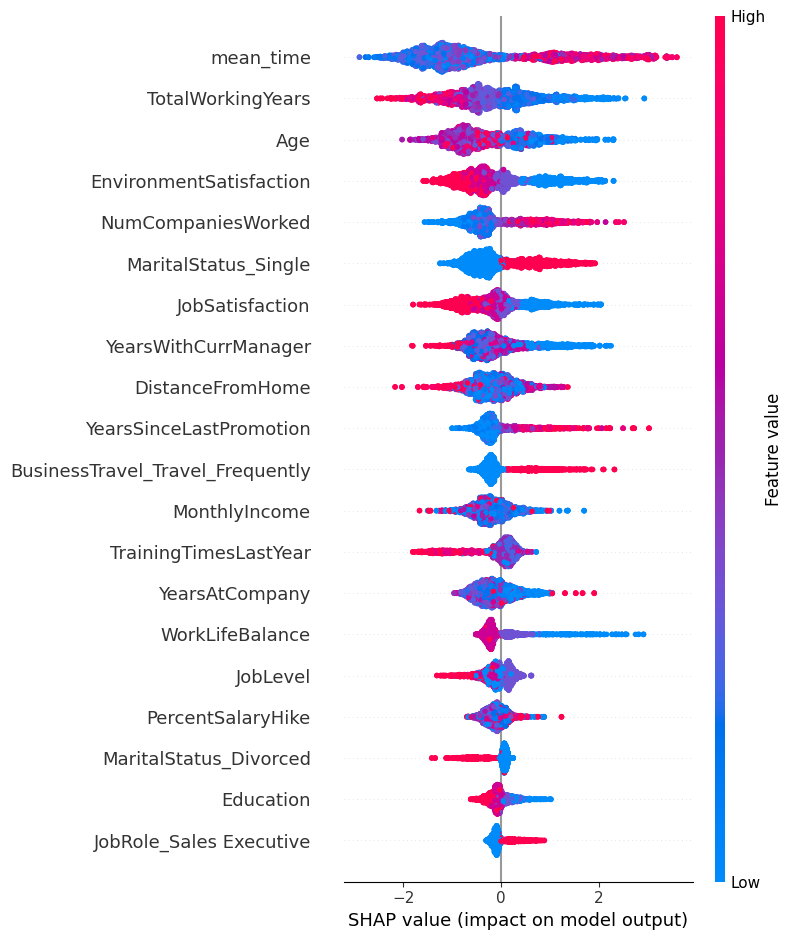

In [8]:
# Importar librerías para calcular los SHAP values
import shap

explainer = shap.Explainer(best_model)  # Crear el objeto explainer
shap_values = explainer.shap_values(X_train)  # Calcular los SHAP values

# Gráfico de SHAP values para cada variable
shap.summary_plot(shap_values, X_train)

TIP para interpretar gráfico SHAP: Mirar el eje X a la derecha y pensar (a valores altos de la variable) y ver si el color es rojo o azul. Si es rojo, aumenta el valor de la predicción final, y si es azul, lo disminuye. 


||||||||||||||||||||||||||||||||||||||||||| CARACTERÍSTICA |||||||||||||||||||||||||||||| IMPACTO |||||||||||||||||||||||||||||||||||||| IMPACTO CONTRARIO
* Entre más tiempo medio trabaje en la compañía es más propenso a renunciar | MUY ALTO | MUY ALTO
* Entre menos años haya trabajado en su vida hasta ahora ese empleado es más propenso a renunciar | MUY ALTO | MUY ALTO
* A valores bajos de la edad es más propenso a que renuncie | MUY ALTO | MUY ALTO
* Entre más insatisfecho este con su ambiente laboral es más propenso a renunciar | ALTO | MUY ALTO
* Si ha trabajado en muchas compañías, el empleado tiende a renunciar | MUY ALTO | ALTO
* Los solteros tienden a renunciar | ALTO | MEDIO
* Entre más insatisfecho este con su trabajo es más propenso a renunciar | ALTO | ALTO
* Entre menos años tenga con su jefe actual es más propenso a renunciar | MEDIO | ALTO
* Entre más cerca viva de su trabajo es más propenso a renunciar | ALTO | BAJO
* Entre más años hayan pasado desde su último asenso es más propenso a renunciar | MUY ALTO | BAJO
* Si el empleado viaja frecuentemente es más propenso a renunciar | ALTO | BAJO
* A los empleados que casi no los capacitan son más propensos a renunciar | MUY ALTO | BAJO
* Los empleados que calificaron bajo su balance vida-trabajo son más propensos a renunciar | BAJO | MUY ALTO
* A un nivel bajo de trabajo en una escala de 1 a 5, el empleado es más propenso a renunciar | MEDIO | MUY BAJO
* Los que no están divorciados son más propensos a renunciar | MEDIO | MUY BAJO
* Entre más bajo sea el nivel de educación del empleado es más propenso a renunciar | BAJO | BAJO
* Si el empleado es del área de Ventas Ejecutivas es más propenso a renunciar | BAJO | MUY BAJO 

Al poner los indicadores de impacto e impacto contrario, se puede tener una idea más clara de que caracteristicas afectan el modelo de manera positiva y negativa, ya que muchas veces se tiene una afirmación pero no necesariamente su negación es cierta.

# Gráfico force plot
Sirve para interpretar un caso en particular y ver las variables que más influyen en la predicción final

Nota: 
* No funciona con LogisticRegression
* No funciona con DecisionTreeClassifier
* No funciona con RandomForestClassifier


In [399]:
# Hacer copia de X_train para quitar la estandarización
X_train_copy = X_train.copy()

# Quitar estandarización de las variables numéricas para utilizar en force_plot
X_train_copy[numeric_columns] = scaler.inverse_transform(X_train_copy[numeric_columns])

# Empleado a evaluar (algo a mejorar es que se pueda buscar por ID, ya que ahora es por posición del split en train)
empleado = 100

# Inicializar javascript
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[empleado, :],  # Valores SHAP del empleado
    X_train_copy.iloc[empleado, :],  # Valores de las variables del empleado
    matplotlib=False,  # True para mostrar como imagen
)

El número en negrita indica el valor SHAP entre más alto es porque hace que aumente la predicción final, en este caso entre más alto sea el valor, más se acerca al target 1 (renuncia)

RESUMEN DEL EMPLEADO 100:
Posiblemente renuncie porque:
* Opina que su trabajo es malo
* Ha trabajado en 5 compañias, lo que es mucho
* Tiene 25 años, con lo que es joven
* Tiene 6 años trabajando lo que es poco


Fuente de gráficos de SHAP
https://www.modeldifferently.com/2023/02/que-es-shap-explicabilidad-de-modelos-shap/